In [ ]:
import pandas as pd

# Load the CSV file
file_path = "/content/tomato_prices_2015-2024.csv"
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60844 entries, 0 to 60843
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sl no.                     60844 non-null  int64 
 1   District Name              60844 non-null  object
 2   Market Name                60844 non-null  object
 3   Commodity                  60844 non-null  object
 4   Variety                    60844 non-null  object
 5   Grade                      60844 non-null  object
 6   Min Price (Rs./Quintal)    60844 non-null  int64 
 7   Max Price (Rs./Quintal)    60844 non-null  int64 
 8   Modal Price (Rs./Quintal)  60844 non-null  int64 
 9   Price Date                 60844 non-null  object
dtypes: int64(4), object(6)
memory usage: 4.6+ MB


(None,
    Sl no. District Name Market Name Commodity Variety Grade  \
 0       1        Hassan   Arakalgud    Tomato  Tomato   FAQ   
 1       2        Hassan   Arasikere    Tomato  Tomato   FAQ   
 2       3        Hassan   Arasikere    Tomato  Tomato   FAQ   
 3       4        Hassan   Arasikere    Tomato  Tomato   FAQ   
 4       5        Hassan   Arasikere    Tomato  Tomato   FAQ   
 
    Min Price (Rs./Quintal)  Max Price (Rs./Quintal)  \
 0                     2500                     2500   
 1                      500                      500   
 2                      667                      667   
 3                     1000                     1000   
 4                     1000                     1000   
 
    Modal Price (Rs./Quintal)   Price Date  
 0                       2500  22 Apr 2023  
 1                        500  16 Nov 2018  
 2                        667  09 Aug 2024  
 3                       1000  01 Jan 2020  
 4                       1000  09 Dec 2020  

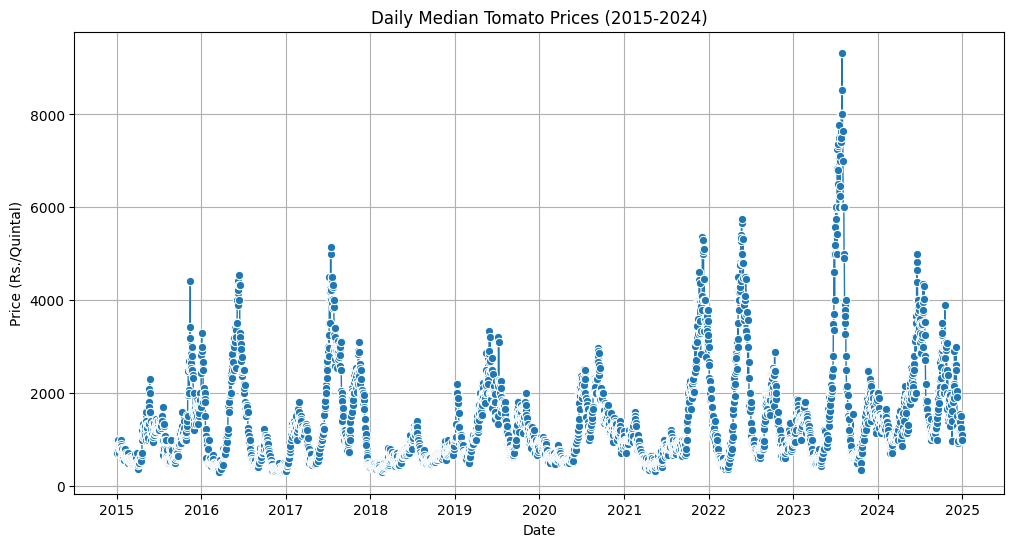

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Price Date' to datetime
df["Price Date"] = pd.to_datetime(df["Price Date"], errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=["Price Date"])

# Aggregate prices by date (taking the median to reduce noise)
df_daily = df.groupby("Price Date")["Modal Price (Rs./Quintal)"].median().reset_index()

# Plot the price trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_daily, x="Price Date", y="Modal Price (Rs./Quintal)", marker="o", linewidth=1)
plt.title("Daily Median Tomato Prices (2015-2024)")
plt.xlabel("Date")
plt.ylabel("Price (Rs./Quintal)")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

df = pd.read_csv("tomato_prices_2015-2024.csv")
df["Price Date"] = pd.to_datetime(df["Price Date"], errors='coerce')
df = df.dropna(subset=["Price Date"])

df_daily = df.groupby("Price Date")["Modal Price (Rs./Quintal)"].median().reset_index()
df_lstm = df_daily.set_index("Price Date")

scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm["Scaled Price"] = scaler.fit_transform(df_lstm[["Modal Price (Rs./Quintal)"]])

train_size = int(len(df_lstm) * 0.8)
train, test = df_lstm[:train_size], df_lstm[train_size:]

def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X_train, y_train = create_sequences(train["Scaled Price"].values, seq_length)
X_test, y_test = create_sequences(test["Scaled Price"].values, seq_length)

# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile and train model
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Forecast next day price
last_30_days = df_lstm["Scaled Price"].values[-seq_length:]
last_30_days = last_30_days.reshape(1, seq_length, 1)
next_day_scaled = model.predict(last_30_days)
next_day_price = scaler.inverse_transform(next_day_scaled.reshape(-1, 1))

print(f"Forecasted price for today: Rs. {next_day_price[0][0]:.2f} per Quintal")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.3496e-04 - val_loss: 0.0018
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.4829e-04 - val_loss: 0.0020
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.6175e-04 - val_loss: 0.0017
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.5827e-04 - val_loss: 0.0016
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.8335e-04 - val_loss: 0.0016
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3807e-04 - val_loss: 0.0018
Epoch 9/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.1283e-04 - val_loss: 0.0015
Epoch 10/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.1107e-04 - val_loss: 0.0015
Epoch 11/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.1234e-04 - val_loss: 0.0016
Epoch 12/20
1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA

# Load the datasets
price_file = "tomato_prices_2015-2024.csv"
rainfall_file = "bangalore-rainfall-data-1900-2024-sept.csv"
df_price = pd.read_csv(price_file)
df_rainfall = pd.read_csv(rainfall_file)

# Preprocess tomato price data
df_price["Price Date"] = pd.to_datetime(df_price["Price Date"], errors='coerce')
df_price = df_price.dropna(subset=["Price Date"])
df_price["Year"] = df_price["Price Date"].dt.year
df_price["Month"] = df_price["Price Date"].dt.month
df_daily = df_price.groupby("Price Date")["Modal Price (Rs./Quintal)"].median().reset_index()

# Preprocess rainfall data
df_rainfall["Year"] = pd.to_numeric(df_rainfall["Year"], errors='coerce')
df_rainfall = df_rainfall[["Year", "June", "July", "Aug", "Sept", "Total"]]

# Merge datasets
df_merged = df_daily.copy()
df_merged["Year"] = df_merged["Price Date"].dt.year
df_merged["Month"] = df_merged["Price Date"].dt.month
df_merged = df_merged.merge(df_rainfall, on="Year", how="left")

# Select relevant features
selected_features = ["Modal Price (Rs./Quintal)", "June", "July", "Aug", "Sept", "Total"]
df_lstm = df_merged[selected_features].dropna()

# Normalize data
scaler = MinMaxScaler()
df_lstm[selected_features] = scaler.fit_transform(df_lstm[selected_features])

# Create sequences for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predicting price
    return np.array(X), np.array(y)

seq_length = 60
train_size = int(len(df_lstm) * 0.85)
train, test = df_lstm.iloc[:train_size], df_lstm.iloc[train_size:]
X_train, y_train = create_sequences(train.values, seq_length)
X_test, y_test = create_sequences(test.values, seq_length)

# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], seq_length, X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], seq_length, X_test.shape[2])

# Build LSTM model
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Train XGBoost model
X_train_xgb, y_train_xgb = train.drop(columns=["Modal Price (Rs./Quintal)"]), train["Modal Price (Rs./Quintal)"]
X_test_xgb, y_test_xgb = test.drop(columns=["Modal Price (Rs./Quintal)"]), test["Modal Price (Rs./Quintal)"]
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train_xgb, y_train_xgb)

# Train ARIMA model
arima_model = ARIMA(train["Modal Price (Rs./Quintal)"], order=(5, 1, 0))
arima_model = arima_model.fit()

# Forecast next day
last_60_days = df_lstm.iloc[-seq_length:].values.reshape(1, seq_length, X_train.shape[2])
lstm_pred = lstm_model.predict(last_60_days)
xgb_pred = xgb_model.predict(df_lstm.iloc[-1:].drop(columns=["Modal Price (Rs./Quintal)"]))
arima_pred = arima_model.forecast(steps=1)

# Convert predictions to proper formats before averaging
lstm_pred_value = lstm_pred[0][0] if isinstance(lstm_pred, np.ndarray) else lstm_pred.iloc[0]
xgb_pred_value = xgb_pred[0] if isinstance(xgb_pred, np.ndarray) else xgb_pred.iloc[0]
arima_pred_value = arima_pred[0] if isinstance(arima_pred, np.ndarray) else arima_pred.iloc[0]

# Combine predictions
final_prediction = (0.5 * lstm_pred_value + 0.3 * xgb_pred_value + 0.2 * arima_pred_value)
final_price = scaler.inverse_transform([[final_prediction] + [0] * (len(selected_features) - 1)])[0][0]

print(f"Fine-tuned forecasted price for today: Rs. {final_price:.2f} per Quintal")


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017 - val_loss: 0.0061
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_loss: 0.0047
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 0.0053
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 10/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 0.0040
Epoch 11/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 12/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Fine-tuned forecasted price for today: Rs. 1156.65 per Quintal
